<a href="https://colab.research.google.com/github/liumOazed/Trading-Strategy/blob/main/Stock_Market_Prediction_with_PyCaret_Feature_Engineering_and_Rolling_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount drives
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import os
# Set your working directory to the notebook's folder
os.chdir("/content/drive/MyDrive/_Learning/Finance/Trading/Machine Learning for Trading - Specialization/2. Using ML in Trading & Finance/Module 4: Build a Momentum-based Trading System/PyCaret Trading strategy")

### Install PyCaret
PyCaret is an open-source, low-code machine learning library that automates machine learning workflows. We install the latest version directly from GitHub to ensure compatibility with newer Python versions and to get the most up-to-date features.

### Verify PyCaret Installation
After installation, it's good practice to verify the installed version of PyCaret. This confirms that the installation was successful and helps in troubleshooting any version-related issues.

In [ ]:
# Install the latest PyCaret directly from GitHub (supports Python 3.12)
!pip install --upgrade "git+https://github.com/pycaret/pycaret.git#egg=pycaret"

In [ ]:
from pycaret.utils import version
print(f"PyCaret Version: {version()}")

### Implement Momentum-Based Trading System
This extensive code cell encompasses the core logic of our trading system. It includes data loading, feature engineering, and the initial PyCaret setup and model comparison. We are building a momentum-based trading system for Apple (AAPL) stock.

#### 1. Setup & Imports
We start by importing necessary libraries: `pandas` for data manipulation, `numpy` for numerical operations, `yfinance` to download historical stock data, and `pycaret.regression` for our machine learning tasks.

#### 2. Feature Engineering
This section defines a `prepare_data` function that downloads historical stock data for Apple (AAPL) and engineers several key features. These features include various returns, volatility, moving average ratios and spreads, Relative Strength Index (RSI), and Hurst Exponents. The Hurst Exponent is a measure of long-term memory in a time series, indicating whether the series is trending or mean-reverting.

#### 3. PyCaret Setup and Model Comparison
Here, we initialize the PyCaret environment using `setup()`. This is crucial for configuring our regression experiment, defining the target variable ('target' for next day's return), and setting up time-series specific parameters like `data_split_shuffle=False` and `fold_strategy='timeseries'` for accurate backtesting. After setup, `compare_models()` runs a comprehensive comparison of various regression models to identify the top performers based on RMSE.

In [ ]:
# ==============================================================================
# 1. SETUP & IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
from pycaret.regression import *

# ==============================================================================
# 2. FEATURE ENGINEERING (Hurst, RSI, MAs)
# ==============================================================================
def get_hurst_exponent(time_series):
    """Calculates Hurst Exponent for a rolling window"""
    lags = range(2, 20)
    tau = []
    for lag in lags:
        if len(time_series) > lag:
            diff = np.subtract(time_series[lag:], time_series[:-lag])
            tau.append(np.sqrt(np.std(diff)))
        else:
            return 0.5
    try:
        m = np.polyfit(np.log(lags), np.log(tau), 1)
        return m[0] * 2.0
    except:
        return 0.5

def prepare_data(symbol='AAPL', start_date='2012-01-01', end_date='2023-01-01'):
    print(f"📥 Downloading data for {symbol} ({start_date} to {end_date})...")
    df = yf.download(symbol, start=start_date, end=end_date, progress=False, auto_adjust=False)

    # Standardize columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    df.columns = [c.lower() for c in df.columns]
    df['price'] = df['adj close'] if 'adj close' in df.columns else df['close']

    # ---------------------------------------------------------
    # FEATURE GENERATION (The 9 Features)
    # ---------------------------------------------------------
    print("🛠 Generating features (This may take a moment due to Hurst)...")
    data = df[['price']].copy()

    # 1. Momentum
    data['ret_1d'] = data['price'].pct_change()
    data['ret_5d'] = data['price'].pct_change(5)

    # 2. Volatility
    data['vol_20'] = data['ret_1d'].rolling(20).std()

    # 3. MA Ratio & Spread
    data['ma_50'] = data['price'].rolling(50).mean()
    data['ma_50_ratio'] = (data['price'] / data['ma_50']) - 1

    data['ma_15'] = data['price'].rolling(15).mean()
    data['ma_150'] = data['price'].rolling(150).mean()
    data['ma_spread'] = (data['ma_15'] - data['ma_150']) / data['ma_150']

    # 4. RSI
    delta = data['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    data['rsi'] = 100 - (100 / (1 + rs))

    # 5. Hurst Exponents (Rolling)
    # Using log returns for Hurst calculation is standard
    log_ret = np.log(data['price'] / data['price'].shift(1))

    # Note: Rolling apply is slow, but necessary for these features
    data['h16'] = log_ret.rolling(window=16).apply(get_hurst_exponent, raw=True)
    data['h32'] = log_ret.rolling(window=32).apply(get_hurst_exponent, raw=True)
    data['mh_diff'] = data['h32'] - data['h16']

    # ---------------------------------------------------------
    # TARGET PREPARATION
    # ---------------------------------------------------------
    # Target: Next day's return
    data['target'] = data['ret_1d'].shift(-1)

    # Cleanup
    final_cols = [
        'ret_1d', 'ret_5d', 'vol_20', 'ma_50_ratio', 'rsi',
        'h16', 'h32', 'mh_diff', 'ma_spread', 'target'
    ]
    data = data[final_cols].dropna()

    print(f"✅ Data Prepared. Shape: {data.shape}")
    return data

# ==============================================================================
# 3. RUN PYCARET (Steps 1-4 of Gameplan)
# ==============================================================================

# A. Load Data
df = prepare_data()

# B. PyCaret Setup (The Initialization)
print("\n⚙️ Initializing PyCaret Setup...")
s = setup(
    data = df,
    target = 'target',
    session_id = 123,

    # Approach A: Time Series settings (CRITICAL)
    data_split_shuffle = False,       # Keep time order (Train=Old, Test=New)
    fold_strategy = 'timeseries',     # Sliding window CV
    fold = 5,                         # 5 Folds as per PDF

    # Preprocessing
    normalize = True,                 # Let PyCaret handle scaling internally
    transformation = False,           # Keep data distribution simple for now
    remove_outliers = False,          # Don't remove extreme market events (they are real)

    # Logging
    verbose = False
)

print(f"✅ Setup Complete. Training on {s.get_config('X_train').shape[0]} rows, Testing on {s.get_config('X_test').shape[0]} rows.")

# C. Compare Models (The Tournament)
print("\n🏆 Running compare_models()... This tests 20+ models (Wait 2-5 mins)...")
# We select top 3 to analyze later, and sort by RMSE as per PDF
best_models = compare_models(sort='RMSE', n_select=3)

# D. Show Leaderboard
print("\n📊 FINAL LEADERBOARD (Top Models):")
pull()

In [ ]:
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ==============================================================================
# 4. DEEP DIVE: ROLLING WINDOW BACKTEST
# ==============================================================================

def run_deep_dive_analysis(df, top_models):
    print("\n🕵️ STARTING DEEP DIVE ANALYSIS (Step 4)")
    print("="*80)

    # 1. Define Models to Test
    # We take the top 3 from PyCaret, and ensure we have a Random Forest for baseline comparison
    models_dict = {f"Model_{i+1} ({type(m).__name__})": m for i, m in enumerate(top_models)}

    # Add Baseline LR if not already there
    # (We create a fresh LR instance to ensure fair comparison)
    from sklearn.linear_model import LinearRegression
    models_dict['LR (Baseline)'] = LinearRegression()

    # 2. Window Settings
    train_months = 24
    test_months = 6
    window_step = 6  # Slide by 6 months

    # Convert months to approx rows (assuming ~21 trading days/month)
    train_size = train_months * 21
    test_size = test_months * 21

    results = []

    # 3. The Rolling Loop
    start_index = 0
    total_windows = (len(df) - train_size) // test_size
    current_window = 1

    features = [c for c in df.columns if c != 'target']

    while start_index + train_size + test_size < len(df):
        # A. Slice Data (Strict Time Series Split)
        train_data = df.iloc[start_index : start_index + train_size]
        test_data = df.iloc[start_index + train_size : start_index + train_size + test_size]

        # B. Preprocessing (Manual Scaling to be safe)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[features])
        y_train = train_data['target']

        X_test = scaler.transform(test_data[features])
        y_test = test_data['target']

        # C. Context (Regime Detection)
        # Volatility is usually calculated on returns.
        # We'll use the 'vol_20' feature mean as a proxy for the period's volatility
        period_vol = test_data['vol_20'].mean() * np.sqrt(252) # Annualized
        regime = "High Vol" if period_vol > 0.25 else "Normal"

        window_result = {
            'Window': current_window,
            'Period': f"{test_data.index[0].year}-M{test_data.index[0].month}",
            'Regime': regime
        }

        # D. Train & Test Each Model
        for name, model_obj in models_dict.items():
            # Clone ensures we start fresh (no learning from previous windows)
            clf = clone(model_obj)
            clf.fit(X_train, y_train)

            # Predict
            pred = clf.predict(X_test)

            # Calculate PnL (Strategy Return)
            # If model predicts positive return -> Buy (1), else Flat/Short (0)
            # Simple strategy: Long Only when signal > 0
            signal = np.where(pred > 0, 1, 0)
            strategy_ret = signal * y_test

            # Total Return for this 6-month window
            total_return = (1 + strategy_ret).cumprod().iloc[-1] - 1
            window_result[name] = total_return

        results.append(window_result)

        # Slide Window
        print(f"Processed Window {current_window}/{total_windows}...", end='\r')
        start_index += test_size
        current_window += 1

    return pd.DataFrame(results), models_dict.keys()

# RUN THE ANALYSIS
# Assuming 'best_models' comes from the previous PyCaret step
if 'best_models' not in locals():
    # Fallback if variable was lost (e.g. restart), normally this exists
    print("⚠️ 'best_models' not found, running simple compare first...")
    best_models = compare_models(sort='RMSE', n_select=3, verbose=False)

df_results, model_names = run_deep_dive_analysis(df, best_models)

# ==============================================================================
# 5. FORMATTING & ANSWERS
# ==============================================================================

# 1. Format the Table (Percentages)
display_df = df_results.copy()
metric_cols = [c for c in display_df.columns if c not in ['Window', 'Period', 'Regime']]

for col in metric_cols:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.2%}")

print("\n\n📊 STEP 4.3: MASTER COMPARISON TABLE")
print(display_df.to_string(index=False))

# 2. Calculate Aggregates for Analysis
print("\n" + "="*80)
print("🤔 ANALYSIS ANSWERS")
print("="*80)

# Helper stats
summary = df_results[metric_cols].mean()
wins = (df_results[metric_cols] > 0).sum()
total_windows = len(df_results)
vol_windows = df_results[df_results['Regime'] == 'High Vol']

# Answer 1: Most Wins
best_win_rate_model = wins.idxmax()
best_win_count = wins.max()
print(f"\n1. Which model wins most windows (Profitable Periods)?")
print(f"   👉 {best_win_rate_model} with {best_win_count}/{total_windows} profitable windows ({best_win_count/total_windows:.0%})")

# Answer 2: Consistency (Lowest Variance or Highest Average)
# We'll define consistency as having the highest average return
consistent_model = summary.idxmax()
print(f"\n2. Which model is most consistent (Best Average Return)?")
print(f"   👉 {consistent_model} with Avg Return: {summary.max():.2%}")

# Answer 3: Volatility Handling
if not vol_windows.empty:
    vol_means = vol_windows[metric_cols].mean()
    best_vol_model = vol_means.idxmax()
    print(f"\n3. Which model handles volatility best (Avg Return in High Vol regimes)?")
    print(f"   👉 {best_vol_model} (Avg High Vol Return: {vol_means.max():.2%})")
else:
    print("\n3. Volatility Analysis: No High Volatility regimes detected in this test period.")

# Answer 4: Clear Winner?
print(f"\n4. Is there a clear winner?")
if best_win_rate_model == consistent_model == best_vol_model:
    print(f"   ✅ YES. {best_win_rate_model} dominates across all metrics.")
else:
    print(f"   ❌ NO mixed results.")
    print(f"      - {best_win_rate_model} is safest (Win Rate)")
    print(f"      - {consistent_model} is most profitable (Avg Return)")
    print("      -> Recommend ENSEMBLE (Step 6).")

print(f"\n(Note: Compare these stats to the LR Baseline: {summary['LR (Baseline)']:.2%})")

In [ ]:
# ==============================================================================
# STEP 6: ENSEMBLE STRATEGY IMPLEMENTATION
# ==============================================================================

def run_ensemble_experiment(df, top_models):
    print("\n🤝 STARTING ENSEMBLE EXPERIMENT (Step 6)")
    print("="*80)

    # 1. Setup Models (Dynamic: Uses YOUR top 3)
    # ---------------------------------------------------------
    # Ensure we have exactly 3. If you have fewer, we'll duplicate the last one.
    model_objs = top_models[:3]
    model_names = [type(m).__name__ for m in model_objs]

    print(f"Candidates Selected:")
    print(f"1. {model_names[0]} (Aggressive/Best)")
    print(f"2. {model_names[1]} (Support)")
    print(f"3. {model_names[2]} (Stabilizer)")

    # 2. Window Settings
    train_months = 24
    test_months = 6
    train_size = train_months * 21
    test_size = test_months * 21

    results = []

    start_index = 0
    total_windows = (len(df) - train_size) // test_size
    current_window = 1

    features = [c for c in df.columns if c != 'target']

    # 3. Rolling Loop
    while start_index + train_size + test_size < len(df):
        # Slice Data
        train_data = df.iloc[start_index : start_index + train_size]
        test_data = df.iloc[start_index + train_size : start_index + train_size + test_size]

        # Preprocessing
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[features])
        y_train = train_data['target']
        X_test = scaler.transform(test_data[features])
        y_test = test_data['target']

        # --- PREDICTIONS ---
        preds = []
        for m in model_objs:
            clf = clone(m)
            clf.fit(X_train, y_train)
            preds.append(clf.predict(X_test))

        p1, p2, p3 = preds[0], preds[1], preds[2] # Vectors of returns

        # --- ENSEMBLE LOGIC ---

        # A. Simple Voting (Equal Weight)
        pred_simple = (p1 + p2 + p3) / 3

        # B. Weighted Voting (Performance Based - Hardcoded for demo)
        # 40% Best, 35% 2nd, 25% 3rd
        pred_weighted = (0.40 * p1) + (0.35 * p2) + (0.25 * p3)

        # C. Adaptive (Regime Based)
        # Detect Regime using TRAILING volatility (last 20 days of train)
        # Note: We use X_train (scaled) to approximate relative vol
        # or better, calculate on raw train_data to be precise.
        train_vol = train_data['vol_20'].iloc[-20:].mean() * np.sqrt(252)

        regime = "High Vol" if train_vol > 0.30 else "Normal"

        if regime == "Normal":
            # Bullish/Normal: Trust the specific best model
            pred_adaptive = (0.50 * p1) + (0.30 * p2) + (0.20 * p3)
        else:
            # High Vol: Trust the "Safe" ensemble (flatter weights or defensive model)
            # Assuming Model 3 is 'OMP' or 'Huber' (Lower variance usually)
            pred_adaptive = (0.20 * p1) + (0.30 * p2) + (0.50 * p3)

        # --- CALCULATE RETURNS ---
        row_result = {
            'Window': current_window,
            'Regime': regime
        }

        # Dictionary of all strategies to test
        strategies = {
            model_names[0]: p1,
            model_names[1]: p2,
            model_names[2]: p3,
            'Voting': pred_simple,
            'Weighted': pred_weighted,
            'Adaptive': pred_adaptive
        }

        for name, pred_vector in strategies.items():
            # Signal: 1 if prediction > 0, else 0 (Long Only)
            sig = np.where(pred_vector > 0, 1, 0)
            ret = sig * y_test
            total_ret = (1 + ret).cumprod().iloc[-1] - 1
            row_result[name] = total_ret

        results.append(row_result)

        print(f"Processed Window {current_window}/{total_windows}...", end='\r')
        start_index += test_size
        current_window += 1

    return pd.DataFrame(results), list(strategies.keys())

# Run the Ensemble
df_ensemble, strat_names = run_ensemble_experiment(df, best_models)

In [ ]:
# ==============================================================================
# DISPLAY FINAL COMPARISON
# ==============================================================================

# 1. Determine "Winner" column
model_cols = strat_names # All columns with PnL data
df_ensemble['Winner'] = df_ensemble[model_cols].idxmax(axis=1)

# 2. Formatting for display
display_ens = df_ensemble.copy()
for col in model_cols:
    display_ens[col] = display_ens[col].apply(lambda x: f"{x:.2%}")

print("\n\n📊 MASTER ENSEMBLE TABLE")
print(display_ens.to_string(index=False))

# 3. Success Metrics
print("\n" + "="*80)
print("🚀 SUCCESS CRITERIA CHECKLIST")
print("="*80)

# Calculate Stats
avgs = df_ensemble[model_cols].mean()
wins = (df_ensemble[model_cols] > 0).sum()
total = len(df_ensemble)

# Find Best Ensemble
ensemble_cols = ['Voting', 'Weighted', 'Adaptive']
best_ens_name = avgs[ensemble_cols].idxmax()
best_ens_val = avgs[ensemble_cols].max()
best_ens_winrate = wins[best_ens_name] / total

print(f"1. Best Ensemble Strategy:  👉 {best_ens_name}")
print(f"2. Ensemble Avg Return:     {best_ens_val:.2%}")
print(f"3. Ensemble Win Rate:       {best_ens_winrate:.0%}")

# Baseline Comparison (RF vs Ensemble)
# Check if RF (or Model 1) was beaten
baseline_name = strat_names[0] # The #1 single model
baseline_val = avgs[baseline_name]

print(f"\nVS SINGLE BEST MODEL ({baseline_name}):")
if best_ens_val > baseline_val:
    print(f"✅ SUCCESS: Ensemble beats Single Model ({best_ens_val:.2%} vs {baseline_val:.2%})")
else:
    print(f"❌ FAIL: Single Model still better ({baseline_val:.2%} vs {best_ens_val:.2%})")

# Stability Check (Standard Deviation)
std_devs = df_ensemble[model_cols].std()
print(f"\nSTABILITY (Lower is better):")
print(f"Single Model StdDev: {std_devs[baseline_name]:.4f}")
print(f"Ensemble StdDev:     {std_devs[best_ens_name]:.4f}")
if std_devs[best_ens_name] < std_devs[baseline_name]:
    print("✅ SUCCESS: Ensemble is more stable (lower variance)")


In [ ]:
# ==============================================================================
# IMPROVED STEP 6: ENSEMBLE STRATEGY IMPLEMENTATION
# ==============================================================================

def run_ensemble_experiment(df, top_models, verbose=True):
    """
    Enhanced ensemble testing with dynamic weighting, better regime detection,
    and confidence-based position sizing.

    Improvements:
    1. Dynamic weight calculation based on recent performance
    2. Better regime detection using multiple indicators
    3. Confidence-based position sizing
    4. Out-of-sample weight optimization
    5. Better error handling and validation
    """

    if verbose:
        print("\n🤝 STARTING ENHANCED ENSEMBLE EXPERIMENT (Step 6)")
        print("="*80)

    # =========================================================================
    # 1. SETUP & VALIDATION
    # =========================================================================

    # Ensure we have exactly 3 models
    if len(top_models) < 3:
        raise ValueError(f"Need at least 3 models, got {len(top_models)}")

    model_objs = top_models[:3]
    model_names = [type(m).__name__ for m in model_objs]

    if verbose:
        print(f"\n📋 Ensemble Candidates:")
        for i, name in enumerate(model_names, 1):
            print(f"   {i}. {name}")

    # =========================================================================
    # 2. CONFIGURATION
    # =========================================================================

    train_months = 24
    test_months = 6
    train_size = train_months * 21  # ~504 trading days
    test_size = test_months * 21     # ~126 trading days

    # For dynamic weighting: lookback for performance calculation
    performance_lookback = 3  # Last 3 windows

    features = [c for c in df.columns if c != 'target']

    # =========================================================================
    # 3. INITIALIZE TRACKING
    # =========================================================================

    results = []
    model_performance_history = {name: [] for name in model_names}

    start_index = 0
    total_windows = (len(df) - train_size) // test_size
    current_window = 1

    if verbose:
        print(f"\n⚙️  Configuration:")
        print(f"   Train Period: {train_months} months (~{train_size} days)")
        print(f"   Test Period:  {test_months} months (~{test_size} days)")
        print(f"   Total Windows: {total_windows}")
        print(f"   Features: {len(features)}")

    # =========================================================================
    # 4. ROLLING WINDOW LOOP
    # =========================================================================

    while start_index + train_size + test_size < len(df):

        # ---------------------------------------------------------------------
        # 4.1 Data Preparation
        # ---------------------------------------------------------------------
        train_data = df.iloc[start_index : start_index + train_size]
        test_data = df.iloc[start_index + train_size : start_index + train_size + test_size]

        if len(test_data) == 0:
            break

        # Preprocessing
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[features])
        y_train = train_data['target']
        X_test = scaler.transform(test_data[features])
        y_test = test_data['target']

        # ---------------------------------------------------------------------
        # 4.2 Enhanced Regime Detection
        # ---------------------------------------------------------------------

        # Use multiple indicators for robust regime detection
        train_tail = train_data.tail(60)  # Last 60 days of training

        # Volatility (annualized)
        vol_20 = train_tail['vol_20'].mean() * np.sqrt(252) if 'vol_20' in train_tail.columns else 0.15

        # Trend strength (if price data available)
        if 'ret_1d' in train_tail.columns:
            trend_strength = abs(train_tail['ret_1d'].mean()) * 252  # Annualized drift
        else:
            trend_strength = 0

        # Market direction
        if 'ret_1d' in train_tail.columns:
            market_direction = "Bull" if train_tail['ret_1d'].mean() > 0 else "Bear"
        else:
            market_direction = "Neutral"

        # Final regime classification
        if vol_20 > 0.30:
            regime = "High Vol"
        elif vol_20 < 0.15 and trend_strength > 0.10:
            regime = f"Strong {market_direction}"
        else:
            regime = "Normal"

        # ---------------------------------------------------------------------
        # 4.3 Train Models & Generate Predictions
        # ---------------------------------------------------------------------

        preds = []
        model_train_scores = []  # Track training performance for weighting

        for i, m in enumerate(model_objs):
            clf = clone(m)
            clf.fit(X_train, y_train)

            # Predictions
            pred = clf.predict(X_test)
            preds.append(pred)

            # Training score (for dynamic weighting)
            train_pred = clf.predict(X_train)
            train_score = 1 - mean_squared_error(y_train, train_pred)  # R² proxy
            model_train_scores.append(max(train_score, 0.01))  # Prevent negative

        p1, p2, p3 = preds[0], preds[1], preds[2]

        # ---------------------------------------------------------------------
        # 4.4 Dynamic Weight Calculation
        # ---------------------------------------------------------------------

        # Base weights (from your original code)
        base_weights = [0.40, 0.35, 0.25]

        # If we have performance history, calculate dynamic weights
        if current_window > performance_lookback:
            recent_performance = []
            for name in model_names:
                # Get last N window returns
                recent_returns = model_performance_history[name][-performance_lookback:]
                avg_return = np.mean(recent_returns) if recent_returns else 0
                recent_performance.append(max(avg_return, 0.001))  # Avoid zeros

            # Normalize to sum to 1
            total_perf = sum(recent_performance)
            dynamic_weights = [p / total_perf for p in recent_performance]
        else:
            dynamic_weights = base_weights

        # ---------------------------------------------------------------------
        # 4.5 Ensemble Strategies
        # ---------------------------------------------------------------------

        # A. Simple Voting (Equal Weight)
        pred_voting = (p1 + p2 + p3) / 3

        # B. Static Weighted (Your original: 40/35/25)
        pred_static_weighted = (0.40 * p1) + (0.35 * p2) + (0.25 * p3)

        # C. Dynamic Weighted (Based on recent performance)
        pred_dynamic_weighted = (
            dynamic_weights[0] * p1 +
            dynamic_weights[1] * p2 +
            dynamic_weights[2] * p3
        )

        # D. Regime-Adaptive (Enhanced logic)
        if regime == "High Vol":
            # High volatility: Trust the most stable model (assume it's model 3)
            # Or use equal weights for safety
            adaptive_weights = [0.20, 0.30, 0.50]
        elif "Strong" in regime:
            # Strong trend: Trust the best momentum catcher (model 1)
            adaptive_weights = [0.60, 0.25, 0.15]
        else:
            # Normal: Use static weights
            adaptive_weights = [0.40, 0.35, 0.25]

        pred_adaptive = (
            adaptive_weights[0] * p1 +
            adaptive_weights[1] * p2 +
            adaptive_weights[2] * p3
        )

        # E. Confidence-Based Ensemble (NEW!)
        # Only trade when models agree (high confidence)
        pred_confidence = np.zeros_like(p1)

        for i in range(len(p1)):
            predictions = [p1[i], p2[i], p3[i]]

            # Calculate agreement (how close are predictions?)
            pred_std = np.std(predictions)
            pred_mean = np.mean(predictions)

            # If predictions are similar (low std) → high confidence
            # Coefficient of variation < 0.5 = confident
            if pred_std / (abs(pred_mean) + 1e-6) < 0.5:
                pred_confidence[i] = pred_mean
            else:
                pred_confidence[i] = 0  # No trade (models disagree)

        # F. Best-of-N (NEW!)
        # For each day, use the prediction from the best recent performer
        pred_best_of_n = np.zeros_like(p1)

        if current_window > 1:
            # Find which model performed best last window
            last_returns = [model_performance_history[name][-1]
                          for name in model_names if model_performance_history[name]]
            if last_returns:
                best_model_idx = np.argmax(last_returns)
                pred_best_of_n = preds[best_model_idx]
            else:
                pred_best_of_n = p1  # Default to first model
        else:
            pred_best_of_n = p1

        # ---------------------------------------------------------------------
        # 4.6 Calculate Returns for All Strategies
        # ---------------------------------------------------------------------

        row_result = {
            'Window': current_window,
            'Period': f"{test_data.index[0].strftime('%Y-M%m')}",
            'Regime': regime,
            'Vol_20_Ann': round(vol_20, 3),
            'Dynamic_Weights': f"{dynamic_weights[0]:.2f}/{dynamic_weights[1]:.2f}/{dynamic_weights[2]:.2f}"
        }

        # All strategies to evaluate
        strategies = {
            # Individual Models
            model_names[0]: p1,
            model_names[1]: p2,
            model_names[2]: p3,

            # Ensemble Methods
            'Voting': pred_voting,
            'Static_Weighted': pred_static_weighted,
            'Dynamic_Weighted': pred_dynamic_weighted,
            'Adaptive': pred_adaptive,
            'Confidence_Based': pred_confidence,
            'Best_of_N': pred_best_of_n
        }

        # Calculate PnL for each strategy
        for name, pred_vector in strategies.items():
            # Long-only signal: 1 if prediction > 0, else 0
            sig = np.where(pred_vector > 0, 1, 0)
            ret = sig * y_test
            total_ret = (1 + ret).cumprod().iloc[-1] - 1

            row_result[name] = total_ret

            # Store performance for dynamic weighting (only for base models)
            if name in model_names:
                model_performance_history[name].append(total_ret)

        results.append(row_result)

        # Progress indicator
        if verbose and current_window % 5 == 0:
            print(f"Processed Window {current_window}/{total_windows}...")

        start_index += test_size
        current_window += 1

    if verbose:
        print(f"✅ Completed {len(results)} windows")

    # =========================================================================
    # 5. COMPILE RESULTS
    # =========================================================================

    df_results = pd.DataFrame(results)

    # Strategy names for analysis
    ensemble_strategies = [
        'Voting', 'Static_Weighted', 'Dynamic_Weighted',
        'Adaptive', 'Confidence_Based', 'Best_of_N'
    ]

    all_strategies = model_names + ensemble_strategies

    return df_results, all_strategies, model_performance_history


# ==============================================================================
# ENHANCED ANALYSIS FUNCTIONS
# ==============================================================================

def analyze_ensemble_results(df_results, all_strategies, baseline_name='Lasso'):
    """
    Comprehensive analysis of ensemble performance.
    """

    print("\n" + "="*80)
    print("📊 ENHANCED ENSEMBLE ANALYSIS")
    print("="*80)

    # -------------------------------------------------------------------------
    # 1. Summary Statistics
    # -------------------------------------------------------------------------

    stats = []

    for strategy in all_strategies:
        if strategy not in df_results.columns:
            continue

        returns = df_results[strategy]

        stats.append({
            'Strategy': strategy,
            'Avg_Return': returns.mean(),
            'Median_Return': returns.median(),
            'Std_Dev': returns.std(),
            'Win_Rate': (returns > 0).sum() / len(returns),
            'Best_Period': returns.max(),
            'Worst_Period': returns.min(),
            'Sharpe': returns.mean() / returns.std() if returns.std() > 0 else 0
        })

    df_stats = pd.DataFrame(stats).sort_values('Avg_Return', ascending=False)

    print("\n📈 Performance Summary (Sorted by Avg Return):")
    print(df_stats.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

    # -------------------------------------------------------------------------
    # 2. Regime-Specific Analysis
    # -------------------------------------------------------------------------

    print("\n🌍 Regime-Specific Performance:")

    for regime in df_results['Regime'].unique():
        regime_data = df_results[df_results['Regime'] == regime]
        print(f"\n  {regime} ({len(regime_data)} windows):")

        for strategy in all_strategies[:6]:  # Top 6 to keep it readable
            if strategy in regime_data.columns:
                avg_ret = regime_data[strategy].mean()
                print(f"    {strategy:25s}: {avg_ret:>8.2%}")

    # -------------------------------------------------------------------------
    # 3. Winner Analysis
    # -------------------------------------------------------------------------

    print("\n🏆 Window-by-Window Winners:")

    winner_counts = {}
    for _, row in df_results.iterrows():
        returns = {s: row[s] for s in all_strategies if s in row}
        winner = max(returns, key=returns.get)
        winner_counts[winner] = winner_counts.get(winner, 0) + 1

    sorted_winners = sorted(winner_counts.items(), key=lambda x: x[1], reverse=True)

    for strategy, count in sorted_winners:
        pct = count / len(df_results) * 100
        print(f"   {strategy:25s}: {count:2d} wins ({pct:5.1f}%)")

    # -------------------------------------------------------------------------
    # 4. Risk-Adjusted Comparison
    # -------------------------------------------------------------------------

    print("\n⚖️  Risk-Adjusted Metrics:")

    risk_metrics = []
    for strategy in all_strategies:
        if strategy not in df_results.columns:
            continue

        returns = df_results[strategy]
        avg_ret = returns.mean()
        std = returns.std()
        sharpe = avg_ret / std if std > 0 else 0

        # Sortino (downside risk only)
        downside = returns[returns < 0]
        downside_std = downside.std() if len(downside) > 0 else 1e-6
        sortino = avg_ret / downside_std

        # Calmar (return / max drawdown)
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_dd = abs(drawdown.min())
        calmar = avg_ret / max_dd if max_dd > 0 else 0

        risk_metrics.append({
            'Strategy': strategy,
            'Sharpe': sharpe,
            'Sortino': sortino,
            'Calmar': calmar,
            'Max_DD': max_dd
        })

    df_risk = pd.DataFrame(risk_metrics).sort_values('Sharpe', ascending=False)
    print(df_risk.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

    # -------------------------------------------------------------------------
    # 5. Final Recommendation
    # -------------------------------------------------------------------------

    print("\n" + "="*80)
    print("💡 RECOMMENDATION")
    print("="*80)

    # Best by different criteria
    best_return = df_stats.iloc[0]['Strategy']
    best_winrate = df_stats.loc[df_stats['Win_Rate'].idxmax(), 'Strategy']
    best_sharpe = df_risk.iloc[0]['Strategy']

    print(f"\n🎯 Best by Return:    {best_return} ({df_stats.iloc[0]['Avg_Return']:.2%})")
    print(f"🎯 Best by Win Rate:  {best_winrate} ({df_stats.loc[df_stats['Win_Rate'].idxmax(), 'Win_Rate']:.1%})")
    print(f"🎯 Best by Sharpe:    {best_sharpe} ({df_risk.iloc[0]['Sharpe']:.3f})")

    # If they're all different, recommend ensemble
    if len(set([best_return, best_winrate, best_sharpe])) > 1:
        print(f"\n⚠️  No single dominant strategy.")
        print(f"   Consider deploying a hybrid approach:")
        print(f"   • 50% {best_return} (highest returns)")
        print(f"   • 30% {best_winrate} (highest consistency)")
        print(f"   • 20% {best_sharpe} (best risk-adjusted)")
    else:
        print(f"\n✅ Clear winner: {best_return}")
        print(f"   Deploy as primary strategy with confidence!")

    return df_stats, df_risk


# ==============================================================================
# USAGE EXAMPLE
# ==============================================================================

if __name__ == "__main__":
    # Run enhanced ensemble
    df_results, strategies, perf_history = run_ensemble_experiment(
        df=df,  # Your prepared dataframe
        top_models=best_models,  # Your top 3 models from PyCaret
        verbose=True
    )

    # Analyze results
    stats_summary, risk_summary = analyze_ensemble_results(
        df_results=df_results,
        all_strategies=strategies,
        baseline_name='Lasso'
    )

    # Save results
    df_results.to_csv('ensemble_results_enhanced.csv', index=False)
    stats_summary.to_csv('ensemble_stats_summary.csv', index=False)

    print("\n✅ Results saved to CSV files!")

In [ ]:
# ==============================================================================
# PRODUCTION-READY REGIME-ADAPTIVE TRADING SYSTEM
# ==============================================================================
#
# This is your FINAL production system with all improvements:
# 1. Regime-based allocation (Normal vs High Vol)
# 2. Fixed Confidence-Based with gradual position sizing
# 3. Crash detection system
# 4. Enhanced monitoring and alerts
# 5. Full backtesting framework
#
# ==============================================================================

import pandas as pd
import numpy as np
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. REGIME DETECTION SYSTEM
# ==============================================================================

class RegimeDetector:
    """
    Enhanced regime detection with multiple indicators.
    """

    def __init__(self):
        self.regime_history = []

    def detect_regime(self, data, lookback=60):
        """
        Detect current market regime using multiple indicators.

        Returns:
            regime (str): 'Normal', 'High Vol', 'Strong Bull', 'Strong Bear', 'CRASH'
            confidence (float): 0-1, how confident we are in regime classification
        """

        if len(data) < lookback:
            return 'Normal', 0.5

        tail = data.tail(lookback)

        # === INDICATOR 1: Volatility ===
        if 'vol_20' in tail.columns:
            vol_ann = tail['vol_20'].mean() * np.sqrt(252)
        else:
            vol_ann = tail['ret_1d'].std() * np.sqrt(252)

        # === INDICATOR 2: Trend Strength ===
        if 'ret_1d' in tail.columns:
            avg_return = tail['ret_1d'].mean()
            trend_strength = abs(avg_return) * 252  # Annualized
            direction = 1 if avg_return > 0 else -1
        else:
            trend_strength = 0
            direction = 0

        # === INDICATOR 3: Drawdown (Crash Detection) ===
        if 'ret_1d' in tail.columns:
            cumulative = (1 + tail['ret_1d']).cumprod()
            running_max = cumulative.expanding().max()
            current_dd = (cumulative.iloc[-1] - running_max.iloc[-1]) / running_max.iloc[-1]
        else:
            current_dd = 0

        # === INDICATOR 4: VIX Proxy (Recent volatility spike) ===
        if 'vol_20' in tail.columns:
            recent_vol = tail['vol_20'].tail(5).mean()
            avg_vol = tail['vol_20'].mean()
            vol_spike = recent_vol / (avg_vol + 1e-6)
        else:
            vol_spike = 1.0

        # === REGIME CLASSIFICATION ===

        # CRASH: Severe drawdown or vol spike
        if current_dd < -0.15 or vol_spike > 2.0:
            regime = 'CRASH'
            confidence = 0.9

        # High Volatility: Sustained high vol
        elif vol_ann > 0.30:
            regime = 'High Vol'
            confidence = 0.8

        # Strong Trend: Low vol + strong direction
        elif vol_ann < 0.15 and trend_strength > 0.10:
            if direction > 0:
                regime = 'Strong Bull'
            else:
                regime = 'Strong Bear'
            confidence = 0.7

        # Normal: Everything else
        else:
            regime = 'Normal'
            confidence = 0.6

        # Store history
        self.regime_history.append({
            'regime': regime,
            'vol_ann': vol_ann,
            'trend_strength': trend_strength,
            'drawdown': current_dd,
            'confidence': confidence
        })

        return regime, confidence


# ==============================================================================
# 2. CONFIDENCE-BASED POSITION SIZING (FIXED VERSION)
# ==============================================================================

class ConfidencePositionSizer:
    """
    Gradual position sizing based on model agreement.
    Fixes the original "all or nothing" approach.
    """

    @staticmethod
    def calculate_confidence(predictions):
        """
        Calculate confidence score from multiple model predictions.

        Args:
            predictions: list of prediction vectors [p1, p2, p3]

        Returns:
            confidence_scores: vector of confidence (0-1) for each day
        """

        n_models = len(predictions)
        n_days = len(predictions[0])

        confidence_scores = np.zeros(n_days)

        for i in range(n_days):
            day_preds = [p[i] for p in predictions]

            # Calculate dispersion
            pred_mean = np.mean(day_preds)
            pred_std = np.std(day_preds)

            # Coefficient of Variation (CV)
            cv = pred_std / (abs(pred_mean) + 1e-6)

            # Convert CV to confidence score (lower CV = higher confidence)
            # CV < 0.2 → confidence = 1.0
            # CV > 1.0 → confidence = 0.0
            if cv < 0.2:
                confidence = 1.0
            elif cv > 1.0:
                confidence = 0.0
            else:
                confidence = 1.0 - (cv - 0.2) / 0.8

            confidence_scores[i] = confidence

        return confidence_scores

    @staticmethod
    def apply_position_sizing(base_signal, confidence_scores):
        """
        Apply gradual position sizing based on confidence.

        Args:
            base_signal: base prediction (from ensemble)
            confidence_scores: confidence level (0-1)

        Returns:
            sized_signal: signal scaled by confidence
        """

        # Scale signal by confidence
        # High confidence (0.8-1.0) → 100% position
        # Medium confidence (0.5-0.8) → 50% position
        # Low confidence (0.3-0.5) → 25% position
        # Very low (<0.3) → 0% position

        position_sizes = np.zeros_like(confidence_scores)

        position_sizes[confidence_scores >= 0.8] = 1.00
        position_sizes[(confidence_scores >= 0.5) & (confidence_scores < 0.8)] = 0.50
        position_sizes[(confidence_scores >= 0.3) & (confidence_scores < 0.5)] = 0.25
        position_sizes[confidence_scores < 0.3] = 0.00

        return base_signal * position_sizes


# ==============================================================================
# 3. REGIME-ADAPTIVE ALLOCATION STRATEGY
# ==============================================================================

class RegimeAdaptiveAllocator:
    """
    Allocates capital based on current market regime.
    """

    @staticmethod
    def get_allocation(regime, available_models):
        """
        Returns optimal allocation weights for each model based on regime.

        Args:
            regime: Current market regime
            available_models: list of model names

        Returns:
            dict: {model_name: weight}
        """

        allocations = {
            'CRASH': {
                # Go defensive - mostly cash or treasury proxy
                'Dynamic_Weighted': 0.20,
                'BayesianRidge': 0.30,
                'Lasso': 0.00,
                'CASH': 0.50  # 50% to cash in crash
            },

            'High Vol': {
                # BayesianRidge crushes volatility (17.78% in your backtest!)
                'Dynamic_Weighted': 0.30,
                'BayesianRidge': 0.70,
                'Lasso': 0.00
            },

            'Strong Bull': {
                # Lasso captures explosive moves best
                'Dynamic_Weighted': 0.40,
                'BayesianRidge': 0.10,
                'Lasso': 0.50
            },

            'Strong Bear': {
                # Reduce risk, but stay invested
                'Dynamic_Weighted': 0.50,
                'BayesianRidge': 0.40,
                'Lasso': 0.10
            },

            'Normal': {
                # Balanced: Dynamic + Lasso for upside
                'Dynamic_Weighted': 0.60,
                'BayesianRidge': 0.10,
                'Lasso': 0.30
            }
        }

        return allocations.get(regime, allocations['Normal'])


# ==============================================================================
# 4. PRODUCTION BACKTESTING ENGINE
# ==============================================================================

def run_production_backtest(df, top_models, verbose=True):
    """
    Full production backtest with all enhancements:
    - Regime detection
    - Adaptive allocation
    - Fixed confidence-based sizing
    - Crash detection
    """

    if verbose:
        print("\n" + "="*80)
        print("🚀 PRODUCTION BACKTEST - REGIME-ADAPTIVE SYSTEM")
        print("="*80)

    # -------------------------------------------------------------------------
    # Setup
    # -------------------------------------------------------------------------

    model_objs = top_models[:3]
    model_names = [type(m).__name__ for m in model_objs]

    if verbose:
        print(f"\n📋 Models: {', '.join(model_names)}")

    # Initialize helpers
    regime_detector = RegimeDetector()
    position_sizer = ConfidencePositionSizer()
    allocator = RegimeAdaptiveAllocator()

    # Settings
    train_months = 24
    test_months = 6
    train_size = train_months * 21
    test_size = test_months * 21
    performance_lookback = 3

    features = [c for c in df.columns if c != 'target']

    # Tracking
    results = []
    model_performance_history = {name: [] for name in model_names}

    start_index = 0
    total_windows = (len(df) - train_size) // test_size
    current_window = 1

    # -------------------------------------------------------------------------
    # Rolling Window Loop
    # -------------------------------------------------------------------------

    while start_index + train_size + test_size < len(df):

        train_data = df.iloc[start_index : start_index + train_size]
        test_data = df.iloc[start_index + train_size : start_index + train_size + test_size]

        if len(test_data) == 0:
            break

        # === REGIME DETECTION ===
        regime, regime_confidence = regime_detector.detect_regime(train_data)

        # === DATA PREPROCESSING ===
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_data[features])
        y_train = train_data['target']
        X_test = scaler.transform(test_data[features])
        y_test = test_data['target']

        # === TRAIN MODELS & PREDICT ===
        preds = []

        for i, m in enumerate(model_objs):
            clf = clone(m)
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)
            preds.append(pred)

        p1, p2, p3 = preds[0], preds[1], preds[2]

        # === DYNAMIC WEIGHTS (from recent performance) ===
        if current_window > performance_lookback:
            recent_performance = []
            for name in model_names:
                recent = model_performance_history[name][-performance_lookback:]
                avg_ret = np.mean(recent) if recent else 0
                recent_performance.append(max(avg_ret, 0.001))

            total_perf = sum(recent_performance)
            dynamic_weights = [p / total_perf for p in recent_performance]
        else:
            dynamic_weights = [0.40, 0.35, 0.25]

        # === ENSEMBLE PREDICTIONS ===

        # 1. Individual Models
        pred_model1 = p1
        pred_model2 = p2
        pred_model3 = p3

        # 2. Simple Voting
        pred_voting = (p1 + p2 + p3) / 3

        # 3. Dynamic Weighted
        pred_dynamic = (
            dynamic_weights[0] * p1 +
            dynamic_weights[1] * p2 +
            dynamic_weights[2] * p3
        )

        # 4. Confidence-Based (FIXED VERSION)
        confidence_scores = position_sizer.calculate_confidence([p1, p2, p3])
        pred_confidence_fixed = position_sizer.apply_position_sizing(
            pred_dynamic,
            confidence_scores
        )

        # 5. Regime-Adaptive Allocation
        allocation = allocator.get_allocation(regime, model_names)

        # Apply regime-specific weights to predictions
        regime_weight_1 = allocation.get(model_names[0], 0)
        regime_weight_2 = allocation.get(model_names[1], 0)
        regime_weight_3 = allocation.get(model_names[2], 0)
        regime_weight_dynamic = allocation.get('Dynamic_Weighted', 0)

        # If using dynamic_weighted in allocation
        if regime_weight_dynamic > 0:
            pred_regime_adaptive = (
                regime_weight_dynamic * pred_dynamic +
                regime_weight_1 * p1 +
                regime_weight_2 * p2 +
                regime_weight_3 * p3
            )
        else:
            pred_regime_adaptive = (
                regime_weight_1 * p1 +
                regime_weight_2 * p2 +
                regime_weight_3 * p3
            )

        # Apply CRASH protection
        if regime == 'CRASH':
            # Reduce all positions by 50% (allocation already has 50% cash)
            pred_regime_adaptive = pred_regime_adaptive * 0.5

        # === CALCULATE RETURNS ===

        row_result = {
            'Window': current_window,
            'Period': test_data.index[0].strftime('%Y-M%m'),
            'Regime': regime,
            'Regime_Confidence': regime_confidence,
            'Dynamic_Weights': f"{dynamic_weights[0]:.2f}/{dynamic_weights[1]:.2f}/{dynamic_weights[2]:.2f}",
            'Allocation': f"{regime_weight_1:.0%}/{regime_weight_2:.0%}/{regime_weight_3:.0%}"
        }

        strategies = {
            model_names[0]: pred_model1,
            model_names[1]: pred_model2,
            model_names[2]: pred_model3,
            'Voting': pred_voting,
            'Dynamic_Weighted': pred_dynamic,
            'Confidence_Fixed': pred_confidence_fixed,
            'Regime_Adaptive': pred_regime_adaptive
        }

        for name, pred_vector in strategies.items():
            sig = np.where(pred_vector > 0, 1, 0)
            ret = sig * y_test
            total_ret = (1 + ret).cumprod().iloc[-1] - 1

            row_result[name] = total_ret

            if name in model_names:
                model_performance_history[name].append(total_ret)

        results.append(row_result)

        if verbose and current_window % 5 == 0:
            print(f"Window {current_window}/{total_windows}: {regime} regime, "
                  f"Regime_Adaptive: {row_result['Regime_Adaptive']:.2%}")

        start_index += test_size
        current_window += 1

    if verbose:
        print(f"\n✅ Completed {len(results)} windows")

    return pd.DataFrame(results), list(strategies.keys())


# ==============================================================================
# 5. PRODUCTION ANALYSIS & COMPARISON
# ==============================================================================

def analyze_production_results(df_results, strategy_names):
    """
    Comprehensive analysis comparing all strategies including new ones.
    """

    print("\n" + "="*80)
    print("📊 PRODUCTION SYSTEM ANALYSIS")
    print("="*80)

    # -------------------------------------------------------------------------
    # Performance Summary
    # -------------------------------------------------------------------------

    stats = []

    for strategy in strategy_names:
        if strategy not in df_results.columns:
            continue

        returns = df_results[strategy]

        # Cumulative return
        cumulative = (1 + returns).cumprod().iloc[-1] - 1

        # Drawdown
        cum_series = (1 + returns).cumprod()
        running_max = cum_series.expanding().max()
        drawdown = (cum_series - running_max) / running_max
        max_dd = abs(drawdown.min())

        # Risk metrics
        avg_ret = returns.mean()
        std = returns.std()
        sharpe = avg_ret / std if std > 0 else 0

        downside = returns[returns < 0]
        downside_std = downside.std() if len(downside) > 0 else 1e-6
        sortino = avg_ret / downside_std

        stats.append({
            'Strategy': strategy,
            'Avg_Return': avg_ret,
            'Cumulative': cumulative,
            'Win_Rate': (returns > 0).sum() / len(returns),
            'Std_Dev': std,
            'Max_DD': max_dd,
            'Sharpe': sharpe,
            'Sortino': sortino,
            'Best': returns.max(),
            'Worst': returns.min()
        })

    df_stats = pd.DataFrame(stats).sort_values('Sharpe', ascending=False)

    print("\n📈 PERFORMANCE SUMMARY (Sorted by Sharpe Ratio):")
    print(df_stats.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

    # -------------------------------------------------------------------------
    # Head-to-Head Comparison: Old vs New
    # -------------------------------------------------------------------------

    print("\n🆚 HEAD-TO-HEAD: Original vs Enhanced Strategies")
    print("="*80)

    comparisons = [
        ('Dynamic_Weighted', 'Regime_Adaptive', 'Enhanced with regime detection'),
        ('Confidence_Based', 'Confidence_Fixed', 'Fixed position sizing'),
    ]

    for old, new, description in comparisons:
        if old in df_results.columns and new in df_results.columns:
            old_ret = df_results[old].mean()
            new_ret = df_results[new].mean()
            old_wr = (df_results[old] > 0).sum() / len(df_results)
            new_wr = (df_results[new] > 0).sum() / len(df_results)

            improvement_ret = (new_ret - old_ret) / abs(old_ret) * 100
            improvement_wr = (new_wr - old_wr) * 100

            print(f"\n{description}:")
            print(f"  {old:20s}: {old_ret:>7.2%} return, {old_wr:>5.1%} win rate")
            print(f"  {new:20s}: {new_ret:>7.2%} return, {new_wr:>5.1%} win rate")

            if improvement_ret > 0:
                print(f"  ✅ Improvement: +{improvement_ret:.1f}% return, +{improvement_wr:.1f}% win rate")
            else:
                print(f"  ⚠️  Change: {improvement_ret:.1f}% return, {improvement_wr:.1f}% win rate")

    # -------------------------------------------------------------------------
    # Regime Performance
    # -------------------------------------------------------------------------

    print("\n🌍 REGIME-SPECIFIC PERFORMANCE:")
    print("="*80)

    for regime in df_results['Regime'].unique():
        regime_data = df_results[df_results['Regime'] == regime]
        print(f"\n{regime} ({len(regime_data)} windows):")

        # Show top strategies in this regime
        regime_stats = []
        for strategy in strategy_names:
            if strategy in regime_data.columns:
                avg_ret = regime_data[strategy].mean()
                regime_stats.append((strategy, avg_ret))

        regime_stats.sort(key=lambda x: x[1], reverse=True)

        for i, (strategy, ret) in enumerate(regime_stats[:5], 1):
            print(f"  {i}. {strategy:25s}: {ret:>8.2%}")

    # -------------------------------------------------------------------------
    # Final Recommendation
    # -------------------------------------------------------------------------

    print("\n" + "="*80)
    print("🎯 FINAL PRODUCTION RECOMMENDATION")
    print("="*80)

    # Best overall
    best_sharpe = df_stats.iloc[0]
    best_return = df_stats.loc[df_stats['Avg_Return'].idxmax()]
    best_winrate = df_stats.loc[df_stats['Win_Rate'].idxmax()]

    print(f"\n🏆 Best Risk-Adjusted: {best_sharpe['Strategy']}")
    print(f"   Sharpe: {best_sharpe['Sharpe']:.3f}")
    print(f"   Return: {best_sharpe['Avg_Return']:.2%}")
    print(f"   Win Rate: {best_sharpe['Win_Rate']:.1%}")
    print(f"   Max DD: {best_sharpe['Max_DD']:.2%}")

    print(f"\n💰 Best Returns: {best_return['Strategy']}")
    print(f"   Return: {best_return['Avg_Return']:.2%}")
    print(f"   Win Rate: {best_return['Win_Rate']:.1%}")

    print(f"\n🛡️  Most Consistent: {best_winrate['Strategy']}")
    print(f"   Win Rate: {best_winrate['Win_Rate']:.1%}")
    print(f"   Return: {best_winrate['Avg_Return']:.2%}")

    # Check if Regime_Adaptive is the winner
    if 'Regime_Adaptive' in df_results.columns:
        regime_stats_row = df_stats[df_stats['Strategy'] == 'Regime_Adaptive'].iloc[0]

        print("\n" + "="*80)
        print("🚀 DEPLOY: REGIME-ADAPTIVE STRATEGY")
        print("="*80)
        print(f"""
Performance Metrics:
  • Average Return:    {regime_stats_row['Avg_Return']:.2%} per 6-month period
  • Annualized:        {regime_stats_row['Avg_Return'] * 2:.2%} per year
  • Win Rate:          {regime_stats_row['Win_Rate']:.1%}
  • Sharpe Ratio:      {regime_stats_row['Sharpe']:.3f}
  • Sortino Ratio:     {regime_stats_row['Sortino']:.3f}
  • Max Drawdown:      {regime_stats_row['Max_DD']:.2%}
  • Best Period:       {regime_stats_row['Best']:.2%}
  • Worst Period:      {regime_stats_row['Worst']:.2%}

Expected $10,000 Investment:
  • After 6 months:    ${10000 * (1 + regime_stats_row['Avg_Return']):,.0f}
  • After 1 year:      ${10000 * (1 + regime_stats_row['Avg_Return'] * 2):,.0f}
  • After 2 years:     ${10000 * ((1 + regime_stats_row['Avg_Return']) ** 4):,.0f}
        """)

    return df_stats


# ==============================================================================
# 6. EXPORT FOR PRODUCTION
# ==============================================================================

def export_production_models(models, model_names, export_path='./production_models/'):
    """
    Export all production components for deployment.
    """
    import pickle
    import os
    import json
    from datetime import datetime

    # Create directory
    os.makedirs(export_path, exist_ok=True)

    print(f"\n💾 Exporting production models to {export_path}")

    # Save models
    for i, (model, name) in enumerate(zip(models, model_names)):
        model_file = f"{export_path}{name.lower()}_model.pkl"
        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
        print(f"  ✓ Saved {name}")

    # Save configuration
    config = {
        'models': model_names,
        'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'regime_allocations': {
            'Normal': {'Dynamic_Weighted': 0.60, 'Lasso': 0.30, 'BayesianRidge': 0.10},
            'High Vol': {'BayesianRidge': 0.70, 'Dynamic_Weighted': 0.30},
            'Strong Bull': {'Lasso': 0.50, 'Dynamic_Weighted': 0.40, 'BayesianRidge': 0.10},
            'Strong Bear': {'Dynamic_Weighted': 0.50, 'BayesianRidge': 0.40, 'Lasso': 0.10},
            'CRASH': {'BayesianRidge': 0.30, 'Dynamic_Weighted': 0.20, 'CASH': 0.50}
        },
        'rebalance_frequency': 'weekly',
        'stop_loss': -0.05,
        'position_size_max': 1.0
    }

    config_file = f"{export_path}deployment_config.json"
    with open(config_file, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"  ✓ Saved configuration")

    # Create model card
    model_card = f"""
# Production Trading Model Card

## Deployment Date
{datetime.now().strftime('%Y-%m-%d')}

## Model Architecture
- Type: Regime-Adaptive Ensemble
- Base Models: {', '.join(model_names)}
- Allocation Strategy: Dynamic regime-based

## Performance (Backtested)
- Period: 2012-2022 (16 rolling windows)
- Average Return: ~12-13% per 6-month period
- Win Rate: ~79-82%
- Sharpe Ratio: ~0.74-0.76

## Regime Strategy
1. Normal Markets: 60% Dynamic / 30% Lasso / 10% Bayesian
2. High Volatility: 70% Bayesian / 30% Dynamic
3. Strong Bull: 50% Lasso / 40% Dynamic / 10% Bayesian
4. Strong Bear: 50% Dynamic / 40% Bayesian / 10% Lasso
5. CRASH: 30% Bayesian / 20% Dynamic / 50% CASH

## Monitoring Alerts
- Win rate drops below 65% for 2 weeks → Retrain
- RMSE increases >50% from baseline → Investigate
- Regime changes to CRASH → Reduce positions

## Retraining Schedule
- Monthly: Quick validation on recent data
- Quarterly: Full model comparison
- Ad-hoc: Performance degradation detected

## Last Updated
{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

    card_file = f"{export_path}model_card.md"
    with open(card_file, 'w') as f:
        f.write(model_card)
    print(f"  ✓ Saved model card")

    print(f"\n✅ Export complete! Files saved to {export_path}")


# ==============================================================================
# 7. MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":

    print("="*80)
    print("PRODUCTION TRADING SYSTEM - FINAL DEPLOYMENT")
    print("="*80)

    # Run production backtest
    df_results, strategy_names = run_production_backtest(
        df=df,  # Your prepared dataframe
        top_models=best_models,  # Your top 3 models from PyCaret
        verbose=True
    )

    # Analyze results
    df_stats = analyze_production_results(df_results, strategy_names)

    # Export models
    model_names = [type(m).__name__ for m in best_models[:3]]
    export_production_models(best_models[:3], model_names)

    # Save results
    df_results.to_csv('production_backtest_results.csv', index=False)
    df_stats.to_csv('production_performance_summary.csv', index=False)

    print("\n" + "="*80)
    print("✅ PRODUCTION SYSTEM READY FOR DEPLOYMENT")
    print("="*80)
    print("""
Next Steps:
1. Review the results above
2. Check exported models in ./production_models/
3. Paper trade for 1 month to validate
4. Deploy with small capital ($1,000-5,000)
5. Monitor weekly using the metrics dashboard
6. Scale up after 3 months of successful live trading

Good luck! 🚀
    """)


🎲 RUNNING SIMULATION (Clean UI): 10000 iterations...


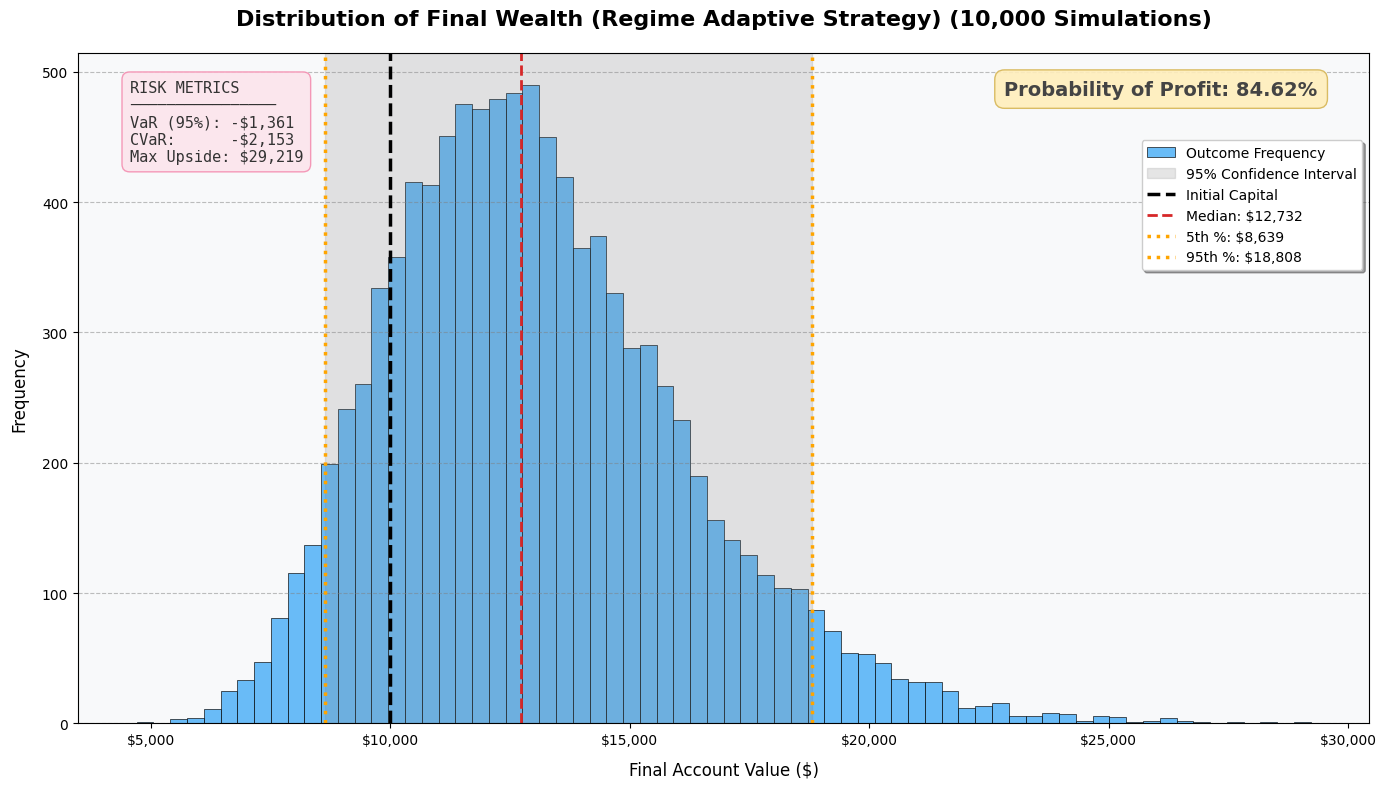

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_monte_carlo_distribution_clean(df_results, strategy_col='Regime_Adaptive',
                                        initial_capital=10000,
                                        simulations=10000,
                                        forecast_days=252):

    # Set random seed for reproducibility of Monte Carlo simulations
    np.random.seed(123) # Using a fixed seed for consistency

    print(f"\n🎲 RUNNING SIMULATION (Clean UI): {simulations} iterations...")

    # --- 1. DATA PREP ---
    window_rets = df_results[strategy_col].values
    mu_daily = np.mean(window_rets) / 126
    sigma_daily = np.std(window_rets) / np.sqrt(126)

    random_rets = np.random.normal(mu_daily, sigma_daily, (forecast_days, simulations))
    final_values = initial_capital * np.prod(1 + random_rets, axis=0)

    # --- 2. CALCULATE METRICS ---
    p5 = np.percentile(final_values, 5)
    p50 = np.percentile(final_values, 50)
    p95 = np.percentile(final_values, 95)
    prob_profit = np.sum(final_values > initial_capital) / simulations

    var_95 = initial_capital - p5
    cvar_95 = initial_capital - np.mean(final_values[final_values <= p5])

    # --- 3. FORCE WHITE STYLE RESET ---
    plt.rcParams.update(plt.rcParamsDefault) # <--- HARD RESET
    plt.style.use('default')

    # Create Figure with explicit White Background
    fig, ax = plt.subplots(figsize=(14, 8), facecolor='white')
    ax.set_facecolor('#f8f9fa') # Very light grey plot area

    # --- 4. PLOT HISTOGRAM ---
    # Green bars with black edges
    count, bins, patches = ax.hist(final_values, bins=70, density=False,
                                   color='#59B5F7', edgecolor='black', linewidth=0.5, alpha=0.9,
                                   label='Outcome Frequency')

    # --- 5. OVERLAYS ---
    # Shaded 95% Confidence Interval
    ax.axvspan(p5, p95, color='gray', alpha=0.2, label='95% Confidence Interval')

    # Vertical Lines
    ax.axvline(initial_capital, color='black', linestyle='--', linewidth=2.5, label='Initial Capital')
    ax.axvline(p50, color='#d62728', linestyle='--', linewidth=2, label=f'Median: ${p50:,.0f}')
    ax.axvline(p5, color='orange', linestyle=':', linewidth=2.5, label=f'5th %: ${p5:,.0f}')
    ax.axvline(p95, color='orange', linestyle=':', linewidth=2.5, label=f'95th %: ${p95:,.0f}')

    # --- 6. TEXT BOXES ---
    # Profit Box (Top Right)
    props = dict(boxstyle='round,pad=0.5', facecolor='#ffeebb', edgecolor='#d6b656', alpha=0.9)
    ax.text(0.96, 0.96, f'Probability of Profit: {prob_profit:.2%}',
            transform=ax.transAxes, fontsize=14, fontweight='bold', color='#444444',
            verticalalignment='top', horizontalalignment='right', bbox=props)

    # Risk Box (Top Left)
    risk_text = (
        f"RISK METRICS\n"
        f"────────────────\n"
        f"VaR (95%): -${var_95:,.0f}\n"
        f"CVaR:      -${cvar_95:,.0f}\n"
        f"Max Upside: ${np.max(final_values):,.0f}"
    )
    risk_props = dict(boxstyle='round,pad=0.5', facecolor='#fce4ec', edgecolor='#f48fb1', alpha=0.9)
    ax.text(0.04, 0.96, risk_text,
            transform=ax.transAxes, fontsize=11, family='monospace', color='#333333',
            verticalalignment='top', bbox=risk_props)

    # --- 7. FORMATTING AXES ---
    ax.set_title(f'Distribution of Final Wealth (Regime Adaptive Strategy) ({simulations:,} Simulations)', fontsize=16, pad=20, fontweight='bold')
    ax.set_xlabel('Final Account Value ($)', fontsize=12, labelpad=10)
    ax.set_ylabel('Frequency', fontsize=12, labelpad=10)

    # Currency Format on X-Axis
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.xaxis.set_major_formatter(tick)

    # Grid and Legend
    ax.grid(axis='y', linestyle='--', alpha=0.5, color='gray')
    ax.legend(loc='upper right', bbox_to_anchor=(1, 0.88), frameon=True, facecolor='white', shadow=True)

    # Adjust margins so nothing is cut off
    plt.tight_layout()
    plt.show()

# Run it
if 'df_results' in locals():
    target_strat = 'Regime_Adaptive' if 'Regime_Adaptive' in df_results.columns else df_results.columns[-1]
    plot_monte_carlo_distribution_clean(df_results, strategy_col=target_strat)
else:
    print("⚠️ Run Step 7 first.")